In [161]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Grayscale

import torch
import torch.nn as nn
import numpy as np
from scipy.signal import gaussian

from torchvision.ops import sigmoid_focal_loss

In [223]:
import torch
import torch.nn as nn
import numpy as np
from scipy.signal import gaussian

class EdgeDetection(nn.Module):
    def __init__(self, threshold=10.0):
        super(EdgeDetection, self).__init__()

        self.threshold = threshold

        filter_size = 5
        generated_filters = gaussian(filter_size,std=1.0).reshape([1,filter_size])

        self.gaussian_filter_horizontal = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,filter_size), padding=(0,filter_size//2))
        self.gaussian_filter_horizontal.weight.data.copy_(torch.from_numpy(generated_filters))
        self.gaussian_filter_horizontal.bias.data.copy_(torch.from_numpy(np.array([0.0])))
        self.gaussian_filter_vertical = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(filter_size,1), padding=(filter_size//2,0))
        self.gaussian_filter_vertical.weight.data.copy_(torch.from_numpy(generated_filters.T))
        self.gaussian_filter_vertical.bias.data.copy_(torch.from_numpy(np.array([0.0])))

        sobel_filter = np.array([[1, 0, -1],
                                 [2, 0, -2],
                                 [1, 0, -1]])

        self.sobel_filter_horizontal = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=sobel_filter.shape, padding=sobel_filter.shape[0]//2)
        self.sobel_filter_horizontal.weight.data.copy_(torch.from_numpy(sobel_filter))
        self.sobel_filter_horizontal.bias.data.copy_(torch.from_numpy(np.array([0.0])))
        self.sobel_filter_vertical = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=sobel_filter.shape, padding=sobel_filter.shape[0]//2)
        self.sobel_filter_vertical.weight.data.copy_(torch.from_numpy(sobel_filter.T))
        self.sobel_filter_vertical.bias.data.copy_(torch.from_numpy(np.array([0.0])))

        # filters were flipped manually
        filter_0 = np.array([   [ 0, 0, 0],
                                [ 0, 1, -1],
                                [ 0, 0, 0]])

        filter_45 = np.array([  [0, 0, 0],
                                [ 0, 1, 0],
                                [ 0, 0, -1]])

        filter_90 = np.array([  [ 0, 0, 0],
                                [ 0, 1, 0],
                                [ 0,-1, 0]])

        filter_135 = np.array([ [ 0, 0, 0],
                                [ 0, 1, 0],
                                [-1, 0, 0]])

        filter_180 = np.array([ [ 0, 0, 0],
                                [-1, 1, 0],
                                [ 0, 0, 0]])

        filter_225 = np.array([ [-1, 0, 0],
                                [ 0, 1, 0],
                                [ 0, 0, 0]])

        filter_270 = np.array([ [ 0,-1, 0],
                                [ 0, 1, 0],
                                [ 0, 0, 0]])

        filter_315 = np.array([ [ 0, 0, -1],
                                [ 0, 1, 0],
                                [ 0, 0, 0]])

        all_filters = np.stack([filter_0, filter_45, filter_90, filter_135, filter_180, filter_225, filter_270, filter_315])

        self.directional_filter = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=filter_0.shape, padding=filter_0.shape[-1] // 2)
        self.directional_filter.weight.data.copy_(torch.from_numpy(all_filters[:, None, ...]))
        self.directional_filter.bias.data.copy_(torch.from_numpy(np.zeros(shape=(all_filters.shape[0],))))

    def forward(self, img):
        img_r = img[:,0:1]
        img_g = img[:,1:2]
        img_b = img[:,2:3]

        print(img_r.device)
        blur_horizontal = self.gaussian_filter_horizontal(img_r)
        blurred_img_r = self.gaussian_filter_vertical(blur_horizontal)
        blur_horizontal = self.gaussian_filter_horizontal(img_g)
        blurred_img_g = self.gaussian_filter_vertical(blur_horizontal)
        blur_horizontal = self.gaussian_filter_horizontal(img_b)
        blurred_img_b = self.gaussian_filter_vertical(blur_horizontal)

        blurred_img = torch.stack([blurred_img_r,blurred_img_g,blurred_img_b],dim=1)
        blurred_img = torch.stack([torch.squeeze(blurred_img)])

        grad_x_r = self.sobel_filter_horizontal(blurred_img_r)
        grad_y_r = self.sobel_filter_vertical(blurred_img_r)
        grad_x_g = self.sobel_filter_horizontal(blurred_img_g)
        grad_y_g = self.sobel_filter_vertical(blurred_img_g)
        grad_x_b = self.sobel_filter_horizontal(blurred_img_b)
        grad_y_b = self.sobel_filter_vertical(blurred_img_b)

        # COMPUTE THICK EDGES

        grad_mag = torch.sqrt(grad_x_r**2 + grad_y_r**2)
        grad_mag += torch.sqrt(grad_x_g**2 + grad_y_g**2)
        grad_mag += torch.sqrt(grad_x_b**2 + grad_y_b**2)
        grad_orientation = (torch.atan2(grad_y_r+grad_y_g+grad_y_b, grad_x_r+grad_x_g+grad_x_b) * (180.0/3.14159))
        grad_orientation += 180.0
        grad_orientation =  torch.round( grad_orientation / 45.0 ) * 45.0

        # THIN EDGES (NON-MAX SUPPRESSION)

        all_filtered = self.directional_filter(grad_mag)

        inidices_positive = (grad_orientation / 45) % 8
        inidices_negative = ((grad_orientation / 45) + 4) % 8

        height = inidices_positive.size()[2]
        width = inidices_positive.size()[3]
        pixel_count = height * width
        pixel_range = torch.FloatTensor([range(pixel_count)]).to(img.device)
        # if self.use_cuda:
        #     pixel_range = torch.cuda.FloatTensor([range(pixel_count)])

        indices = (inidices_positive.view(-1).data * pixel_count + pixel_range).squeeze()
        channel_select_filtered_positive = all_filtered.view(-1)[indices.long()].view(1,height,width)

        indices = (inidices_negative.view(-1).data * pixel_count + pixel_range).squeeze()
        channel_select_filtered_negative = all_filtered.view(-1)[indices.long()].view(1,height,width)

        channel_select_filtered = torch.stack([channel_select_filtered_positive,channel_select_filtered_negative])

        is_max = channel_select_filtered.min(dim=0)[0] > 0.0
        is_max = torch.unsqueeze(is_max, dim=0)

        thin_edges = grad_mag.clone()
        thin_edges[is_max==0] = 0.0

        # THRESHOLD

        thresholded = thin_edges.clone()
        thresholded[thin_edges<self.threshold] = 0.0

        early_threshold = grad_mag.clone()
        early_threshold[grad_mag<self.threshold] = 0.0

        assert grad_mag.size() == grad_orientation.size() == thin_edges.size() == thresholded.size() == early_threshold.size()

        return blurred_img, grad_mag, grad_orientation, thin_edges, thresholded, early_threshold

In [224]:
toTensor = ToTensor()
toGray = Grayscale()

In [225]:
img_path_gt = '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/output/data_nerf_synthetic_hq_reception_mupltiple_gaussian_splatting_pa-lr-0.001_qtvec/test/ours_40000/renders_localizations/00015_gt.png'

img_path_init = '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/output/data_nerf_synthetic_hq_reception_mupltiple_gaussian_splatting_pa-lr-0.001_qtvec/test/ours_40000/renders_localizations/00015_15.3407_0.6889_0.5861_orig_lie.png'

img_path_final = '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/output/data_nerf_synthetic_hq_reception_mupltiple_gaussian_splatting_pa-lr-0.001_qtvec/test/ours_40000/renders_localizations/00015_29.6781_0.9515_0.1494_adj_lie_rotlr_0.01.png'

In [226]:
img_gt = toTensor(Image.open(img_path_gt)).unsqueeze(0)

img_init = toTensor(Image.open(img_path_init)).unsqueeze(0)

img_final = toTensor(Image.open(img_path_final)).unsqueeze(0)

In [227]:
edge_detection = EdgeDetection()

In [228]:
edge_detection = edge_detection.cuda()

In [241]:
img_init.shape

torch.Size([1, 3, 540, 960])

: 

In [230]:
blurred_img, grad_mag, grad_orientation, thin_edges, thresholded, early_threshold = edge_detection(img_gt.cuda())

_, _, _, _, thresholded_init, _ = edge_detection(img_init)

_, _, _, _, thresholded_final, _ = edge_detection(img_final)

cuda:0
cpu


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

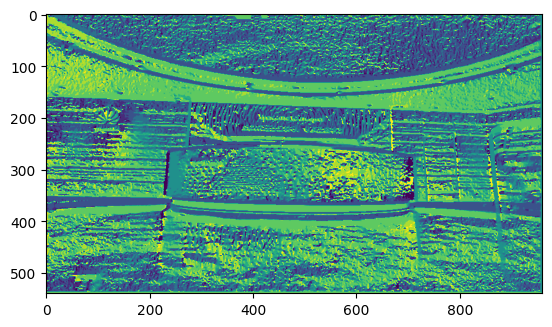

In [238]:
plt.imshow(grad_orientation.cpu().detach().numpy().squeeze())

In [239]:
grad_orientation.shape

torch.Size([1, 1, 540, 960])

In [184]:
thresholded_gt  = (thresholded_gt > 0).to(dtype=float)
thresholded_init  = (thresholded_init > 0).to(dtype=float)
thresholded_final  = (thresholded_final > 0).to(dtype=float)

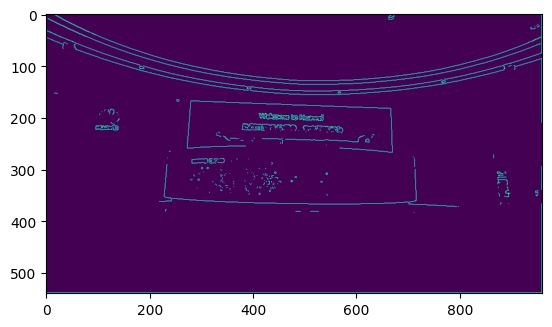

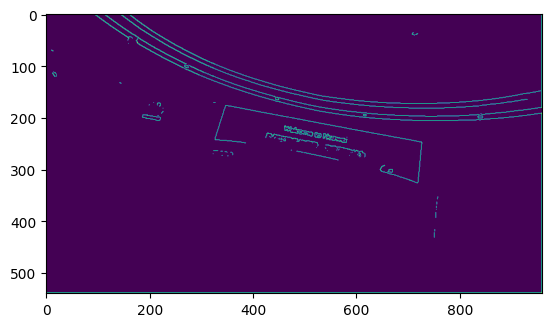

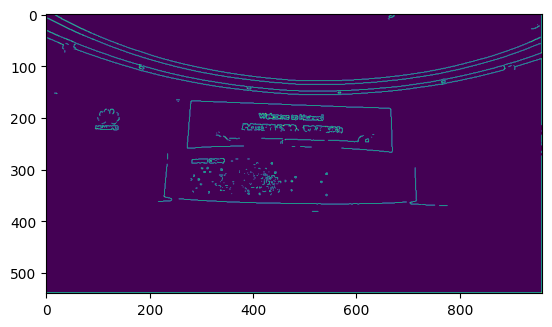

In [185]:
plt.imshow(thresholded_gt.squeeze().detach().numpy())
plt.show()

plt.imshow(thresholded_init.squeeze().detach().numpy())
plt.show()

plt.imshow(thresholded_final.squeeze().detach().numpy())
plt.show()

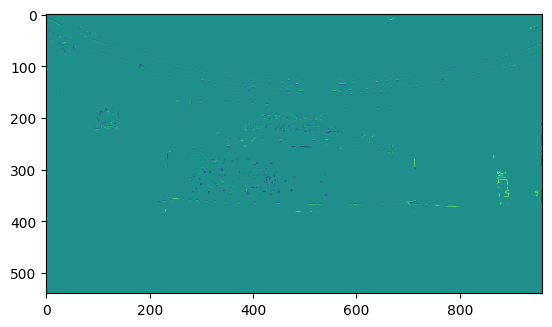

In [195]:
plt.imshow((thresholded_gt - thresholded_final).squeeze())

In [198]:
torch.abs((thresholded_gt - thresholded_final)).mean()

tensor(0.0047, dtype=torch.float64)

In [199]:
torch.abs((thresholded_gt - thresholded_init)).mean()

tensor(0.0253, dtype=torch.float64)

In [190]:
sigmoid_focal_loss(thresholded_final.squeeze(), thresholded_gt.squeeze(), reduction='mean')

tensor(0.1285, dtype=torch.float64)

In [191]:
sigmoid_focal_loss(thresholded_init.squeeze(), thresholded_gt.squeeze(), reduction='mean')

tensor(0.1322, dtype=torch.float64)

In [179]:
from torch.nn.functional import one_hot

one_hot(thresholded_final).squeeze().permute((2,0,1))

torch.Size([2, 540, 960])

In [164]:
thresholded_final.shape

torch.Size([1, 1, 540, 960])

In [133]:
sigmoid_focal_loss()

TypeError: sigmoid_focal_loss() missing 2 required positional arguments: 'inputs' and 'targets'

In [ ]:
loss

In [102]:
img_tensor.shape

torch.Size([1, 1, 540, 960])

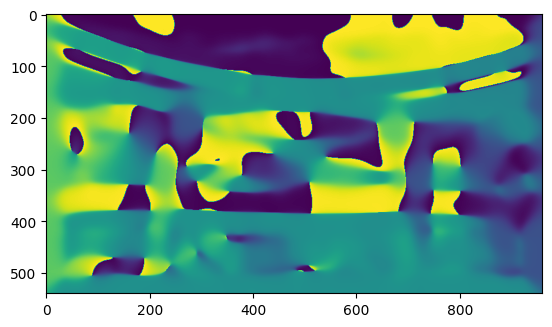

In [80]:
plt.imshow(res[1].squeeze())

In [8]:
with open('/mnt/sdb1/home/kbotashev/3DGS/data/planck_1211/image_list_path.txt') as f:
    data = [line.split('.png')[0] for line in f.readlines()]

In [21]:

with open('/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/output/3DGS_data_planck_1211_pa-lr-0.001_1_to_5_full_whole_traj_adj_1e-3/images_adj.txt', 'w') as fwid:
    with open('/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/output/3DGS_data_planck_1211_pa-lr-0.001_1_to_5_full_whole_traj_adj_1e-3/adjusted_cameras_test_final.txt', 'r') as frid:
        for line in frid.readlines():   
            line_split = line.replace('\n', '').split(' ')
            new_line = ' '.join([line_split[0]] + line_split[2:] +['1',  line_split[1] + '.png'])
            fwid.write(new_line)
            fwid.write('\n')
            fwid.write('1 2 3')
            fwid.write('\n')
            # break
            # fwid.write(line)            

In [19]:
new_line

'0 0.8419553637504578 0.01232934184372425 -0.5393283367156982 0.009172477759420872 -2.76739239692688 -0.11229410022497177 6.068172931671143 frame_IMG_1357_00013.png'

In [1]:
import cv2
import matplotlib.pyplot as plt
from glob import glob

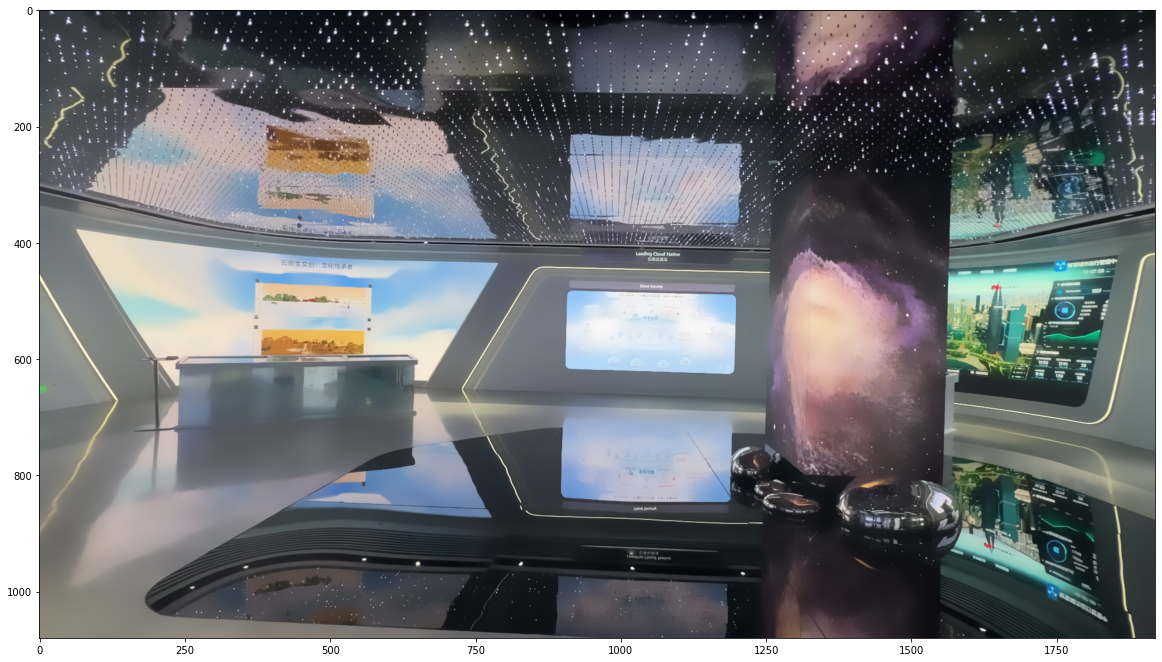

In [12]:
directory = glob('/mnt/sdb1/home/kbotashev/3DGS/data/planck_1211_refined/images/*')

img = cv2.cvtColor(cv2.imread(directory[100]), cv2.COLOR_BGR2RGB)

img = cv2.bilateralFilter(img, 32, 50, 50)

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

In [2]:
import numpy as np

In [4]:
np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]]).T

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])